In [26]:
# System
import os
from os.path import join, basename, dirname, exists

# For submission
import csv
import copy

# Computational
import numpy as np
import pandas as pd
import ast
import random

# Images and augmentation
from scipy.ndimage import imread
from imgaug import augmenters as iaa
from PIL import Image

# Analysis and plots
from collections import Counter
from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)
%matplotlib inline

# Deep learning
import keras
from keras import backend as K

# Pre-trained models imports
from keras.applications import vgg16, xception

# Preprocessing imports
from keras.applications.imagenet_utils import decode_predictions
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Layer imports
from keras.layers import Flatten, Dense
from keras import Model

# Probably not needed anymore?
from sklearn.metrics import fbeta_score

data_dir = "D:/MLiP/data/"
#data_dir = "F:/MLiP/data/"

## Functions needed for (testing) the batch generator

In [27]:
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    # image = np.interp(image, [np.min(image), np.max(image)], [range_min, range_max])

    return image

In [28]:
def labels_one_hot(labels):
    
    onehot_label = [0.] * 228
    for label in labels:
        onehot_label[int(label) - 1] = 1.
    
    return onehot_label

In [29]:
def pad_image(image_arr, final_size=(299,299), pad_color=(255, 255, 255)):
    img = Image.fromarray(image_arr)
    x, y = img.size
    aspect = x / y

    if (x < final_size[0]) and (y < final_size[1]):
        new_img = Image.new("RGB", final_size, color=pad_color)
        new_img.paste(img, ((final_size[0]-x)//2, (final_size[1]-y)//2))
        return np.array(new_img) / 255.0
    elif (x == final_size[0]) and (y == final_size[1]):
        return np.array(img) / 255.0
    else:
        new_img = Image.new("RGB", final_size, color=pad_color)
        larger_dim = 0 if x > y else 1
        if larger_dim == 0:
            new_x = final_size[0]
            new_y = int(y * new_x / x)
        else:
            new_y = final_size[1]
            new_x = int(x * new_y / y)
        img_resize = img.resize((new_x, new_y), Image.ANTIALIAS)
        new_img = Image.new("RGB", final_size, color=pad_color)
        new_img.paste(img_resize, ((final_size[0] - new_x)//2, (final_size[1] - new_y)//2))
        return np.array(new_img) / 255.0

In [30]:
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()

# Re-reating the image index per label dataframe
I had some troubles parsing the .csv that Alex made, so I re-made it.

In [6]:
# Creating the right csv
basic_df = pd.DataFrame.from_csv(join(data_dir, "csv/train_labels.csv"))
evaluated = basic_df['labelId'].apply(lambda x: ast.literal_eval(x))

# Following code was use to re-create the .csv
# label_images = [[] for _ in range(228)]
# for i, row in enumerate(evaluated):
#     for label in row:
#         label_images[int(label)-1].append(i)

# proper_df = pd.DataFrame(
#     {'imageIdx': label_images,
#      'labelId': list(range(1,229))     
#     })
# proper_df.head()
# proper_df.to_csv('idx_per_label.csv')

idx_csv_df = pd.DataFrame.from_csv(join(data_dir, 'csv/idx_per_label.csv'))
idx_label_df = idx_csv_df['imageIdx'].apply(lambda x: ast.literal_eval(x)) # labels to int

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:18: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls



## This is how the label sampling works (code copied to generator)
Plot shows that each label is selected at least once per macrobatch_size images. Original distribution is still very much the same.

In [16]:
macrobatch_size = 1024

image_ids = set([])
labels = set([])
all_labels = []

label_range = list(range(1,229))
random.shuffle(label_range)
for label in [str(i) for i in label_range]:
    if label not in labels:
        # Add image with label to img_idx
        img_id = random.choice(idx_label_df.iloc[int(label)-1]) + 1
        image_ids = image_ids | set([img_id]) # add id

        # Add labels from taken image to labels
        new_labels = evaluated.iloc[img_id - 1]
        labels = labels | set(new_labels)
        all_labels.append(new_labels)

while len(image_ids) < macrobatch_size:
    image_ids = image_ids | set([random.randint(1, len(basic_df))])

all_labels = [x for sublist in all_labels for x in sublist]

You can use the following plot with different macrobatch_size values to see how the distribution looks. Each label should have at least one image.

In [17]:
train_labels = Counter(all_labels)

xvalues = list(train_labels.keys())
yvalues = list(train_labels.values())

trace1 = go.Bar(x=xvalues, y=yvalues, opacity=0.8, name="year count", marker=dict(color='rgba(20, 20, 20, 1)'))
layout = dict(width=800, title='Distribution of different labels in the batch', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [21]:
print(len(image_ids))

1024


## The generator
Takes a while to initialize but should be pretty fast at creating batches after that.

In [33]:
class BalancedBatchGenerator(object):

    def __init__(self, input_dir, csv_path, mini_batch_size=32, macro_batch_size=1024, augmentation_fn=pad_image):

        # Params
        self.input_dir = input_dir  # path to images
        self.csv_path = csv_path  # path to CSV
        self.mini_batch_size = mini_batch_size  # number of images per mini batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Info
        self.n_samples = len(self.df)
        self.n_batches = self.n_samples // self.mini_batch_size
        
        # Macro batch related
        self.macro_batch_size = macro_batch_size # size of bigger batch to take mini batches from
        self.macro_batch_ids = [] # initialize empty macro batch
        basic_df = pd.DataFrame.from_csv(join(data_dir, "csv/train_labels.csv"))
        self.evaluated = basic_df['labelId'].apply(lambda x: ast.literal_eval(x)) # idx to int
        idx_csv_df = pd.DataFrame.from_csv(join(data_dir, 'csv/idx_per_label.csv'))
        self.idx_label_df = idx_csv_df['imageIdx'].apply(lambda x: ast.literal_eval(x)) # labels to int
        
        # Print some info
        print('BatchGenerator detected: {n_samples} image samples.'.format(n_samples=self.n_samples))

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        
        if len(self.macro_batch_ids) == 0:
            self.create_macro_batch()
        
        # Take mini batch from macro batch
        minibatch_ids = self.macro_batch_ids[:32]
        self.macro_batch_ids = self.macro_batch_ids[32:]

        # Take records with mini batch indices from dataframe
        df_batch = self.df.iloc[minibatch_ids]

        # Iterate over selected images 
        images = []
        labels = []
        for idx, row in df_batch.iterrows():

            try:

                # Read image path
                img_id = row['imageId']
                image_path = self.input_dir + "/" + str(img_id) + ".jpg"

                # Read data and label
                image = load_image(image_path)
                label = labels_one_hot(ast.literal_eval(row['labelId']))

                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image_arr=image)

                # Append
                images.append(image)
                labels.append(label)
                
            except Exception as e:
                print('Failed reading image {idx}.jpg'.format(idx=img_id))
            
        # Assemble batch
        batch_x = np.array(images)
        batch_y = np.array(labels)

        n_batches = self.macro_batch_size / self.mini_batch_size
        return batch_x, batch_y
    
    def create_macro_batch(self):
        
        # Creates a macro_batch_size batch with each label at least once
        image_ids = set([])
        labels = set([])

        # Go through labels in random order
        label_range = list(range(1,229))
        random.shuffle(label_range)
        for label in [str(i) for i in label_range]:
            if label not in labels:
                # Add image with label to img_ids
                img_id = random.choice(self.idx_label_df.iloc[int(label)-1]) + 1
                image_ids = image_ids | set([img_id]) # add id

                # Add labels from taken image to labels
                new_labels = self.evaluated.iloc[img_id - 1]
                labels = labels | set(new_labels)

        # Add images until size is right
        while len(image_ids) < self.macro_batch_size:
            image_ids = image_ids | set([random.randint(1, len(self.evaluated))])
        
        # Shuffle to be sure
        image_ids = list(map(lambda x: x - 1, image_ids)) # from imageId to index
        random.shuffle(image_ids)
        
        # Set macro batch and assert right length
        self.macro_batch_ids = image_ids
        assert(len(self.macro_batch_ids) == self.macro_batch_size)

In [34]:
# Initialize generator (takes quite some time)
training_gen = BalancedBatchGenerator(
    input_dir = join(data_dir, "train"),
    csv_path = join(data_dir, "csv/train_labels.csv"),
)

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:21: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:23: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls



BatchGenerator detected: 1014544 image samples.


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:

`imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.



(32, 299, 299, 3)
(32, 228)


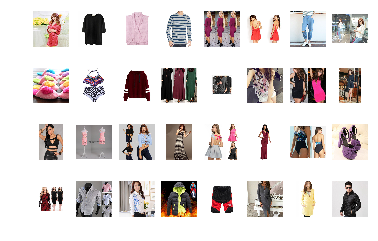

In [36]:
# Test the generator
for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

## Proof that it works
Code above (Test the generator) has to be changed for this to work again.

In [23]:
test = [np.sum(i, axis=0) for i in all_batch_y]
test2 = np.sum(test, axis=0)
print(test2)

[  1.  17.   4.   4.   6.   5.  25.   1.  16.   4.   5.   1.   7.  20.
  11.   1. 255.  42. 127. 112.   4.   2.   2.   1.   7.   9.   3.  10.
   2.   2.   8.  11.   3.   4.   5.  64.   7.  11.   7.   7.   1.   5.
   4.  84.   4.   1.  14.   8.  55.   2.  10.   9. 128.   4.   9.   8.
   2.   4.  31.   2.  18. 113.  20.   4.  13. 753.   5.   2.  10.  43.
  10.   3.  38.   9.   4.   1.  10.  58.  72.   3.   7.   8.   1.   1.
   3.   1.  17.  22.   5.   3.  32.   9.   8.   1.  18.   4.  29.  96.
  22.  15.  10.   2.   6.   1. 325. 204.   1.   2.  10.  34.   6.   3.
  67.  10.  29.  55.  14.   8.   1.   5.   4.  34.   1.   1.   1.   7.
   3.  28.   3.   4.  47.   9.  62.   1.  21.   4.  90.  89.   9.   6.
   7.  34.  15.  22.   1.   3.   9. 112.   2.  11.  27.   4. 266.  41.
  26.   1.   1.  10.  18.   2.   1.   1.   1. 112.  14.  30.  11.   7.
   5.  34. 242.   1.   1.   1.  41.  58.   3.  11.   1.  44.  19.   1.
  15.  70.   9.  65.   4.   3.  15.  34.   2.   2.  32.   2.   2.   3.
   1. 

As we can see, there are no zeros in the array, which is a column-wise sum of all 16 batches, indicating that each label is selected at least once.
## Ideas: parameters for training the best network

In [17]:
batch_size = 32
steps_per_epoch = 1600
epochs = 400 # bit much innit?
# 20 million = 20 times the whole data set
print('Total images seen:', batch_size * steps_per_epoch * epochs)

Total images seen: 20480000
